In [203]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=False)

x, y = torch.tensor(iris["data"]).to(torch.float), torch.tensor(iris["target"])
# print(x.shape)

About Dataset

- Feature space

'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'

- Label space

'setosa', 'versicolor', 'virginica'

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# from sklearn.model_selection import train_test_split

How to visualize the high dimensional space(n(dji)+1) into 3 dimensional space?

-> Use only random 2 directional vectors for bridging this issue! (intuitive visualization methods)

There's some problem! The scale invariant property of relu activation function indicates that we should normalize random vectors to keep under-control! The popular way to alleviate this issue by simple techniques [Filter-wise normalization technique](https://proceedings.neurips.cc/paper_files/paper/2018/file/a41b3bb3e6b050b6c9067c67f663b915-Paper.pdf).

-> Dij <- Dij/|Dij| * thetaij

Dji = random vector

In [280]:
@torch.no_grad
def get_loss_landscape(net, data_x, data_y, loss_func):
    interested_p = {}
    for n, p in net.named_parameters():
        if "weight" in n:
            # interested_p.append(n)
            # out = [(curr:=curr*v) for v in p.shape][-1]
            interested_p[n] = p
    res = 100
    x, y = torch.linspace(-0.1, 0.1, res), torch.linspace(-1, 1, res)
    grid = torch.meshgrid(x, y) # [2, (20, 20)]

    a = grid[0]
    b = grid[1]
    d_n = {}
    for key, p in interested_p.items():
        directions = []
        for i in range(2):
            random_d = torch.randn_like(p)
            normed_d = random_d / random_d.norm(-1) * p
            directions.append(normed_d)
        v1 = directions[0]
        v2 = directions[1]
        shape = p.shape
        delv1 = v1.reshape(-1).unsqueeze(0).unsqueeze(0) * a.unsqueeze(2)
        delv2 = v2.reshape(-1).unsqueeze(0).unsqueeze(0) * b.unsqueeze(2)
        d_n[key] = (delv1.view(res, res, shape[0], shape[1]), delv2.view(res, res, shape[0], shape[1]))

    losses = torch.zeros(res, res)
    for i in range(res):
        for j in range(res):
            cloned_network = deepcopy(net)
            for n, p in cloned_network.named_parameters():
                if n not in d_n.keys():
                    continue
                shape = p.shape
                d1 = d_n[n][0][i, j]
                d2 = d_n[n][1][i, j]
                p += d1 + d2
                # print(p.shape, shape)
            yhat = cloned_network(data_x)
            loss = loss_func(data_y, yhat)
            losses[i, j] = loss.item()
    return losses

In [281]:
class Net(nn.Module):
    def __init__(self, act):
        super().__init__()
        self.linear1 = nn.Linear(4, 10)
        self.linear2 = nn.Linear(10, 10)
        self.linear3 = nn.Linear(10, 3)
        self.linear4 = nn.Linear(4, 3)
        # self.relu = nn.ReLU()
        self.act = act
    def forward(self, x):
        res_x = self.linear4(x)        
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        # x = self.linear3(x) + res_x
        return x

def loss_func(y, yhat):
    return torch.nn.functional.cross_entropy(yhat, y, reduction="mean")

In [282]:
tanh_net = Net(nn.Tanh())
relu_net = Net(nn.ReLU())
leaky_net = Net(nn.LeakyReLU())

tanh_optimizer = torch.optim.SGD(tanh_net.parameters(), 0.05)
relu_optimizer = torch.optim.SGD(relu_net.parameters(), 0.05)
leaky_optimizer = torch.optim.SGD(leaky_net.parameters(), 0.05)

initial_relu_landscape = get_loss_landscape(relu_net, x, y, loss_func).detach().numpy()
initial_leaky_landscape = get_loss_landscape(leaky_net, x, y, loss_func).detach().numpy()
initial_tanh_landscape = get_loss_landscape(tanh_net, x, y, loss_func).detach().numpy()

In [283]:
loss_func(y, relu_net(x))

tensor(2.4193, grad_fn=<NllLossBackward0>)

Text(0.5, 1.0, 'Tanh')

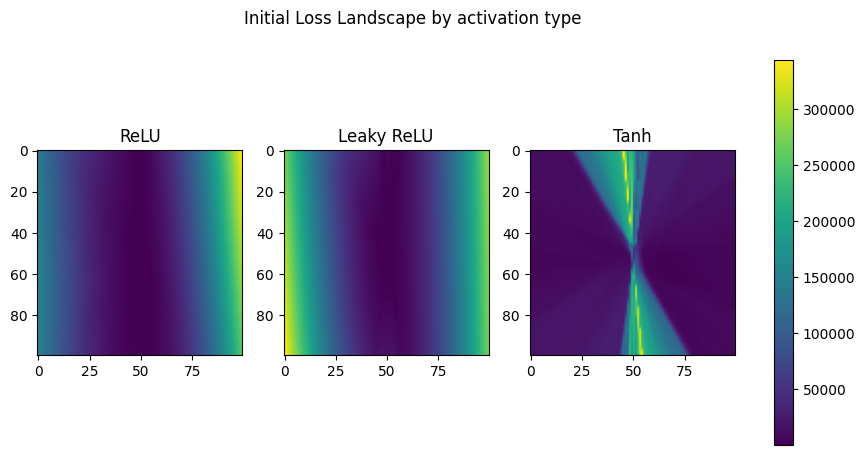

In [284]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

im0 = ax[0].imshow(initial_relu_landscape, cmap="viridis")
im1 = ax[1].imshow(initial_leaky_landscape, cmap="viridis")
im2 = ax[2].imshow(initial_tanh_landscape, cmap="viridis")
# ax[0].set_colorbar()

cbar = fig.colorbar(im0, ax=ax, orientation="vertical", fraction=0.05, pad=0.05)

fig.suptitle("Initial Loss Landscape by activation type")
ax[0].set_title("ReLU")
ax[1].set_title("Leaky ReLU")
ax[2].set_title("Tanh")

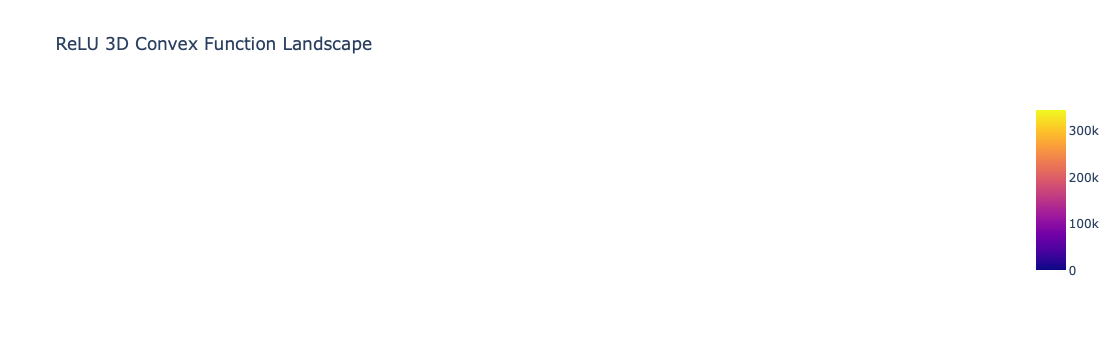

In [286]:
import plotly.graph_objects as go

res = 100
X, Y = torch.meshgrid(torch.linspace(-0.1, 0.1, res), torch.linspace(-0.1, 0.1, res))

# Create a plotly surface plot
fig = go.Figure(data=[go.Surface(z=initial_relu_landscape, x=X, y=Y)])

fig.update_layout(
    title="ReLU 3D Convex Function Landscape",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Loss"
    )
)

fig.show()


In [ ]:
import plotly.graph_objects as go

res = 100
X, Y = torch.meshgrid(torch.linspace(-0.1, 0.1, res), torch.linspace(-0.1, 0.1, res))

# Create a plotly surface plot
fig = go.Figure(data=[go.Surface(z=initial_relu_landscape, x=X, y=Y)])

fig.update_layout(
    title="ReLU 3D Convex Function Landscape",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Loss"
    )
)

fig.show()
